In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv('exchange_rate.csv', parse_dates=['date'])

In [3]:
# Set 'Date' as the index
data.set_index('date', inplace=True)

In [4]:
# Explore the data
print(data.head())

                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB
None


In [6]:
print(data.describe())

           Ex_rate
count  7588.000000
mean      0.776974
std       0.136620
min       0.483297
25%       0.701422
50%       0.761377
75%       0.873477
max       1.102536


<Figure size 1200x600 with 0 Axes>

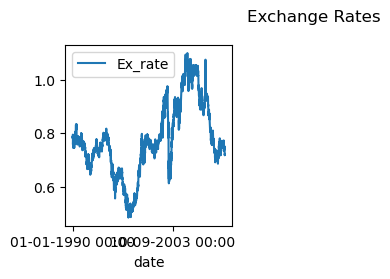

In [7]:
# Plot the time series
plt.figure(figsize=(12, 6))
data.plot(subplots=True, layout=(2, 3), title='Exchange Rates')
plt.tight_layout()
plt.show()

In [11]:
from statsmodels.tsa.arima_model import ARIMA

# Stationarity check (ADF test)
result = sm.tsa.stattools.adfuller(data['Ex_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.664994180738073
p-value: 0.44923273535983155
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [15]:
# Differencing  if necessary
if result[1] > 0.05:  # Not stationary, apply differencing
    data['Ex_rate'] = data['Ex_rate'].diff().dropna()


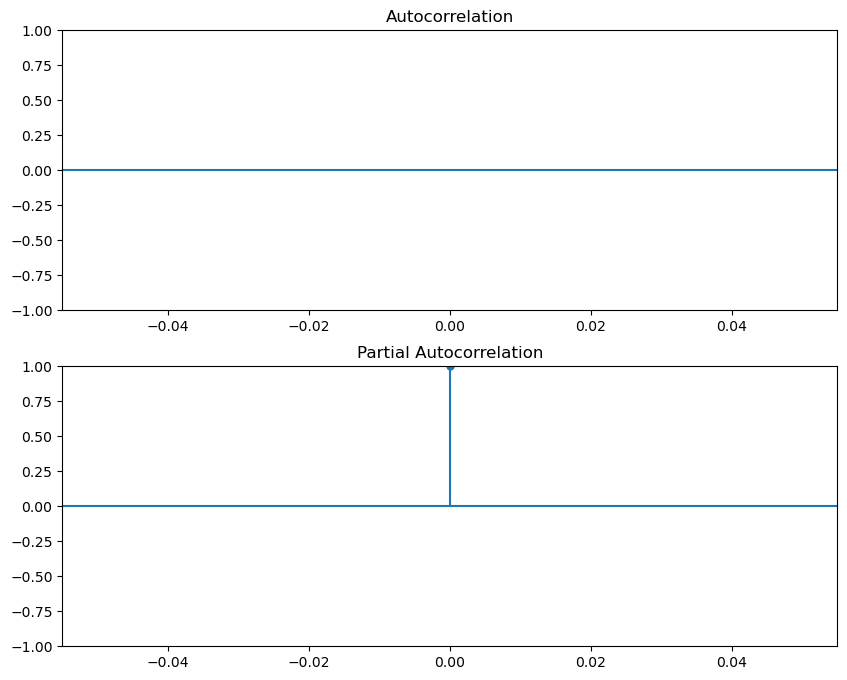

In [17]:
# ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(data['Ex_rate'], ax=ax[0])
sm.graphics.tsa.plot_pacf(data['Ex_rate'], ax=ax[1])
plt.show()

In [52]:
# Model fitting
import warnings
warnings.filterwarnings('ignore')
# Model fitting
p, d, q = 1, 1, 2  # Adjust these values based on ACF and PACF plots
model_arima = ARIMA(data['Ex_rate'], order=(p, d, q))
model_fit_arima = model_arima.fit()
print(model_fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 2)   Log Likelihood               27983.836
Date:                Tue, 01 Oct 2024   AIC                         -55959.671
Time:                        16:55:59   BIC                         -55931.934
Sample:                             0   HQIC                        -55950.152
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8601      0.030    -28.516      0.000      -0.919      -0.801
ma.L1         -0.1626      0.031     -5.303      0.000      -0.223      -0.103
ma.L2         -0.8268      0.031    -26.495      0.0

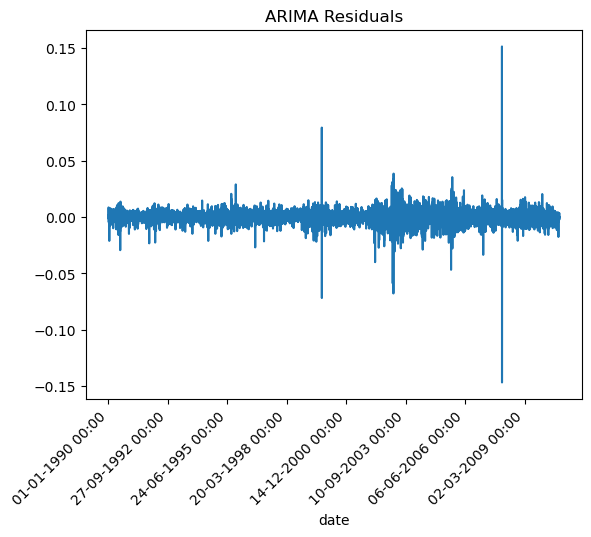

In [55]:
# Residuals analysis
import numpy as np
residuals_arima = model_fit_arima.resid
residuals_arima.plot(title='ARIMA Residuals')
# Increase the spacing between x-axis ticks
plt.xticks(rotation=45, ha='right')
# Adjust the number of ticks displayed based on your data length
#plt.xticks(np.arange(len(residuals))[:10:2])
plt.show()

In [56]:

# Forecasting
from statsmodels.tsa.arima.model import ARIMA
forecast_arima = model_fit_arima.forecast(steps=30)

In [57]:
# Handle NaN values in forecast (if necessary)
from statsmodels.tsa.arima.model import ARIMA
forecast_arima = forecast_arima.fillna(method='ffill')

In [93]:
# Calculate evaluation metrics
mae_arima = mean_absolute_error(data['Ex_rate'][-30:], forecast_arima)
rmse_arima = mean_squared_error(data['Ex_rate'][-30:], forecast_arima, squared=False)
mape_arima = mean_absolute_percentage_error(data['Ex_rate'][-30:], forecast_arima)
print('mean_absolute_error:',mae_arima)
print('mean_squared_error:',rmse_arima)
print('mean_absolute_percentage_error:',mape_arima)


mean_absolute_error: 0.0021529914294823914
mean_squared_error: 0.003766245602674824
mean_absolute_percentage_error: 75142460354.86934


In [59]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Exponential Smoothing Model

# Model fitting
model_exp_smoothing = ExponentialSmoothing(data['Ex_rate'], trend='additive', seasonal='additive', seasonal_periods=12)
model_fit_exp_smoothing = model_exp_smoothing.fit()

In [60]:
# Forecasting
forecast_exp_smoothing = model_fit_exp_smoothing.forecast(steps=30)

In [63]:
print(data['Ex_rate'][-30:].isnull().sum())
print(forecast_exp_smoothing.isnull().sum())

0
30


In [76]:
# Check data types
print("data['Ex_rate'].dtype:", data['Ex_rate'].dtypes)
print("forecast_exp_smoothing.dtype:", forecast_exp_smoothing.dtypes)


data['Ex_rate'].dtype: float64
forecast_exp_smoothing.dtype: float64


In [78]:
# Handle NaN values in forecast (if necessary)
# Using custom imputation with Exponential Smoothing model
def impute_nan_exp_smoothing(series, model):
    for i in range(len(series)):
        if pd.isna(series.iloc[i]):
            # Use Exponential Smoothing model to predict missing value
            imputed_value = model.predict(start=i, end=i)
            series.iloc[i] = imputed_value
    return series

forecast_exp_smoothing = impute_nan_exp_smoothing(forecast_exp_smoothing.copy(), model_fit_exp_smoothing)


In [94]:
# Ensure data and forecast have the same length
if len(data['Ex_rate'][-30:]) != len(forecast_exp_smoothing):
    raise ValueError("data_last_30 and forecast_exp_smoothing have different lengths!")

# Check for data type inconsistencies (more detailed)
if data['Ex_rate'][-30:].dtypes != forecast_exp_smoothing.dtypes:
    print("Data type mismatch:")
    print("data_last_30 dtype:", data['Ex_rate'][-30:].dtypes)
    print("forecast_exp_smoothing dtype:", forecast_exp_smoothing.dtypes)
    # If necessary, convert data types for consistency
    # data_last_30 = data_last_30.astype(forecast_exp_smoothing.dtypes)  # Example conversion

# Handle NaN values using the chosen method (ffill in this example)
data_last_30 = data['Ex_rate'][-30:].fillna(method='ffill')

# Double-check for remaining NaN values
print("NaN values in data_last_30 (after fill):", data_last_30.isnull().sum())
print("Indices with NaN values in data_last_30:")
print(data_last_30.isnull().idxmax())  # Check specific indices

# Handle remaining NaN values in data_last_30 (if applicable)

# Investigate NaN values in forecast_exp_smoothing
print("NaN values in forecast_exp_smoothing:", forecast_exp_smoothing.isnull().sum())



# Calculate evaluation metrics (if no remaining NaNs)
if data_last_30.isnull().sum() == 0 and forecast_exp_smoothing.isnull().sum() == 0:
    mae_exp_smoothing = mean_absolute_error(data_last_30, forecast_exp_smoothing)
    rmse_exp_smoothing = mean_squared_error(data_last_30, forecast_exp_smoothing, squared=False)
    mape_exp_smoothing = mean_absolute_percentage_error(data_last_30, forecast_exp_smoothing)
    # Print the evaluation metrics
    print("MAE:", mae_exp_smoothing)
    print("RMSE:", rmse_exp_smoothing)
    print("MAPE:", mape_exp_smoothing)

NaN values in data_last_30 (after fill): 0
Indices with NaN values in data_last_30:
11-09-2010 00:00
NaN values in forecast_exp_smoothing: 29
